# IALP Stategy Analysis - Final Report

In [104]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import pmdarima as pm
import plotly.graph_objects as go
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
from src.plotting import *
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from src.utils import *
plt.style.use("ggplot")
plt.rcParams.update({"font.size": 14, "axes.labelweight": "bold", "figure.figsize": (7,5), "lines.linewidth": 2})
plt.rcParams['figure.facecolor'] = 'white'




# Part 1. Revenue

## 1.1 Data Preparation



In [105]:
ialp = pd.read_csv('/Users/warroom/Desktop/IALP_analysis/data/processed/IALP_Monthly_Revenue.csv', index_col=0, parse_dates=True)
ialp.head()

,Revenue
Year_Month,
2019-01-01,13592.90
2019-02-01,12056.32
2019-03-01,22004.13
2019-04-01,11650.20
2019-05-01,10213.00


## 1.2 STL 



### **STL (Seasonal-Trend decomposition using Loess)** is a method that splits a time series into trend, seasonal, and residual components using locally weighted regression.


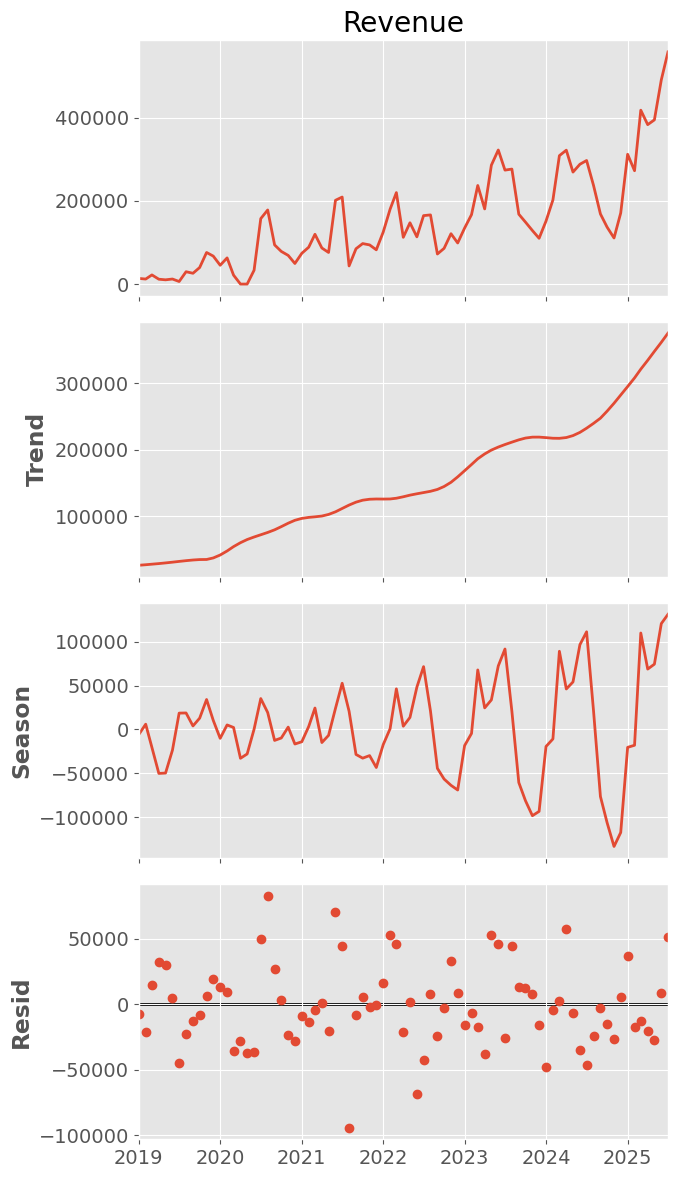

In [106]:
# Decompose the data with STL 
model = STL(ialp["Revenue"], period=12, seasonal=13).fit()
with mpl.rc_context():
    mpl.rc("figure", figsize=(7, 12))
    model.plot()

plt.show()

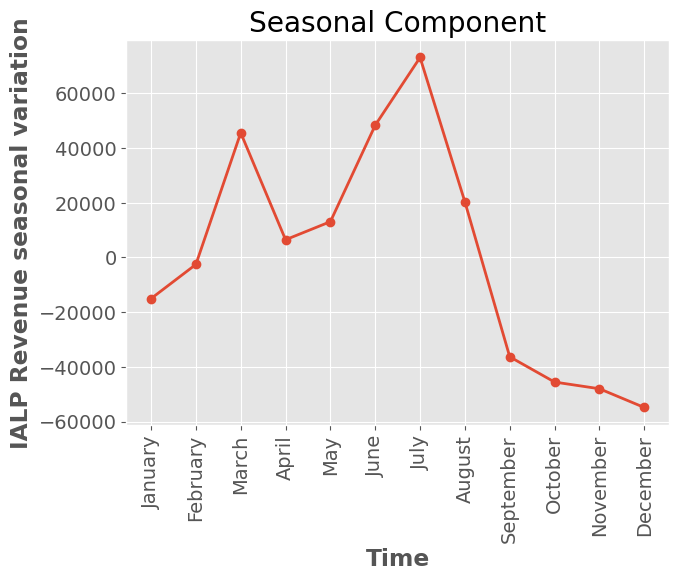

In [107]:
import calendar  
# Plot the seasonal component
seasonal = model.seasonal.groupby(model.seasonal.index.month).mean()
seasonal.plot.line(xlabel="Time", ylabel="IALP Revenue seasonal variation", marker="o")
plt.xticks(range(1, 13), calendar.month_name[1:], rotation='vertical')
plt.title("Seasonal Component")
plt.show();

### The whole data set show obvious trend, seasonality, and signals of autocorrelation.

## 1.3 Apply Model for Revenue Forecasting

### We finished model comparison at model.ipynb, so here just apply the best-performing model, STL+ARIMA.

In [108]:
# STL + ARIMA Forecasting

# ======== Parameter ========
H = 18            # forecast horizon
M = 12            # seasonal period (12 for monthly data with yearly seasonality)
USE_DAMPED = False

y = ialp['Revenue'].astype(float).copy()
y.index = pd.to_datetime(y.index)  # make sure index is datetime
y = y.asfreq('MS')

# ======== log1p transform ========
if (y < 0).any():
    raise ValueError("Negative values found in data, log1p is not suitable. Please shift the data or use additive STL.")
y_log = np.log1p(y)

# ======== STL decompose ========
stl = STL(y_log, period=M, robust=True)
stl_res = stl.fit()
trend_log, season_log, resid_log = stl_res.trend, stl_res.seasonal, stl_res.resid

# ======== Trend forecasting ========
trend_model = ExponentialSmoothing(
    trend_log.dropna(), trend='add', seasonal=None, damped_trend=USE_DAMPED
).fit(optimized=True)

future_index = pd.date_range(start=y.index[-1] + pd.DateOffset(months=1), periods=H, freq='MS')
trend_fc_log = pd.Series(trend_model.forecast(H), index=future_index)

# ======== Seasonal forecasting ========
if len(season_log) >= M:
    season_template = season_log.iloc[-M:]
else:
    # Create a simple date range for the seasonal template
    template_start = y.index[-M] if len(y) >= M else y.index[0]
    season_template = pd.Series(np.zeros(M), 
                               index=pd.date_range(start=template_start, periods=M, freq='MS'))

season_fc_log = pd.Series(np.resize(season_template.values, H), index=future_index)

# ======== Residual Forecasting ========
arima_resid = pm.auto_arima(resid_log.dropna(), seasonal=False, d=None,
                            start_p=0, start_q=0, max_p=5, max_q=5,
                            stepwise=True, trace=False,
                            error_action='ignore', suppress_warnings=True)

resid_fc_log = pd.Series(arima_resid.predict(n_periods=H), index=future_index)

# ======== Ensemble results（STL+ARIMA）========
yhat_log = trend_fc_log + season_fc_log + resid_fc_log
yhat_stl_arima = np.expm1(yhat_log)


In [109]:
# Add the seasonal naive model for comparison, which is a simple yet effective baseline for seasonal data.
# ======== Seasonal Naive Model ========
def seasonal_naive_forecast(data, periods, season_length=12):
    """
    Seasonal Naive predict: used last year's same period value.
    
    Parameters:
    - data: history (pd.Series)
    - periods: prediction periods (int)
    - season_length: season_length (int)
    """
    forecast = []
    data_values = data.values
    
    for i in range(periods):
        # for i-th forecasted point from last year
        seasonal_idx = len(data_values) - season_length + (i % season_length)
        
        # if index is applicable, else use the last value
        if seasonal_idx >= 0:
            forecast.append(data_values[seasonal_idx])
        else:
            forecast.append(data_values[-1])
    
    return pd.Series(forecast, index=future_index)

# generate seasonal naive forecast
yhat_seasonal_naive = seasonal_naive_forecast(y, H, M)

# ======== Ensemble forecase(avg. of two forecast results, we cam adjust the weight here)========
yhat_ensemble = (yhat_stl_arima + yhat_seasonal_naive) / 2

# ======== Historical/Future Trend (Back to Original Scale)）======== 
trend_hist = pd.Series(np.expm1(trend_log), index=trend_log.index)
trend_future = pd.Series(np.expm1(trend_fc_log), index=future_index)




In [110]:
# Visalization
# ======== Plotly  ========
fig = go.Figure()

# Historical data
fig.add_trace(go.Scatter(
    x=y.index, y=y.values,
    mode='lines+markers', name='Historical Revenue',
    line=dict(color='blue', width=2),
    marker=dict(size=4)
))

# STL+ARIMA forecast data
fig.add_trace(go.Scatter(
    x=yhat_stl_arima.index, y=yhat_stl_arima.values,
    mode='lines+markers', name='STL+ARIMA Forecast',
    line=dict(color='orange', dash='dot', width=2),
    marker=dict(size=4)
))

# Seasonal Naive forecast data
fig.add_trace(go.Scatter(
    x=yhat_seasonal_naive.index, y=yhat_seasonal_naive.values,
    mode='lines+markers', name='Seasonal Naive Forecast',
    line=dict(color='lightblue', dash='dash', width=2),
    marker=dict(size=4)
))

# Combined Forecast (Average of Both Models)
fig.add_trace(go.Scatter(
    x=yhat_ensemble.index, y=yhat_ensemble.values,
    mode='lines+markers', name='Ensemble Forecast (Average)',
    line=dict(color='red', dash='dashdot', width=3),
    marker=dict(size=5, symbol='diamond')
))

# Historical trend
fig.add_trace(go.Scatter(
    x=trend_hist.index, y=trend_hist.values,
    mode='lines', name='Historical Trend',
    line=dict(color='green', width=1.5),
    opacity=0.7
))

# Future trend
fig.add_trace(go.Scatter(
    x=trend_future.index, y=trend_future.values,
    mode='lines', name='Future Trend',
    line=dict(color='orange', dash='dot', width=1.5),
    opacity=0.7
))

# Layout Optimization
fig.update_layout(
    title="Revenue Forecast Comparison: STL+ARIMA vs Seasonal Naive vs Ensemble (18 Months)",
    xaxis_title="Date",
    yaxis_title="Revenue",
    hovermode="x unified",
    template="plotly_white",
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ),
    width=1200,
    height=700
)

# Grid
#fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
#fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

fig.show()


In [111]:

# ======== Result Comparison ========
print("=== Result Comparison ===")
rev_result = pd.DataFrame({
    'Date': future_index,
    'STL+ARIMA': yhat_stl_arima.values,
    'Seasonal_Naive': yhat_seasonal_naive.values,
    'Ensemble_Average': yhat_ensemble.values
})


#rev_result['STL_vs_SN_Diff'] = rev_result['STL+ARIMA'] - rev_result['Seasonal_Naive']
#rev_result['STL_vs_SN_Diff_Pct'] = (rev_result['STL_vs_SN_Diff'] / rev_result['Seasonal_Naive']) * 100

# Store the results
rev_result.to_csv('/Users/warroom/Desktop/IALP_analysis/outputs/predictions/forecast_comparison.csv', index=False)



# ======== Model Difference Analysis ========
print("\n=== Model Difference Analysis ===")
stl_vs_sn_mean_diff = (yhat_stl_arima - yhat_seasonal_naive).mean()
stl_vs_sn_std_diff = (yhat_stl_arima - yhat_seasonal_naive).std()
print(f"STL+ARIMA vs Seasonal Naive Mean Difference: {stl_vs_sn_mean_diff:.2f}")
print(f"STL+ARIMA vs Seasonal Naive Standard Difference: {stl_vs_sn_std_diff:.2f}")

print(f"Ensemble as a median forecast may provide more robust results")


=== Result Comparison ===

=== Model Difference Analysis ===
STL+ARIMA vs Seasonal Naive Mean Difference: 171306.16
STL+ARIMA vs Seasonal Naive Standard Difference: 76414.66
Ensemble as a median forecast may provide more robust results


In [112]:
rev_result.round(2)

,Date,STL+ARIMA,Seasonal_Naive,Ensemble_Average
0,2025-08-01,418606.78,237461.42,328034.10
1,2025-09-01,262556.26,168672.70,215614.48
2,2025-10-01,207978.08,136879.08,172428.58
3,2025-11-01,174945.43,110852.07,142898.75
4,2025-12-01,234306.32,171061.93,202684.12
5,2026-01-01,420851.60,312146.94,366499.27
6,2026-02-01,398188.57,272658.68,335423.62
7,2026-03-01,620646.34,418240.38,519443.36
8,2026-04-01,614893.22,383482.91,499188.06
9,2026-05-01,611863.80,394966.68,503415.24


In [113]:
rev_2026 = rev_result.loc[rev_result['Date'].between('2026-01-01', '2026-12-31')]
totals = rev_2026[['STL+ARIMA', 'Seasonal_Naive', 'Ensemble_Average']].sum().rename('Total_2026')
totals

STL+ARIMA           5.956456e+06
Seasonal_Naive      3.656038e+06
Ensemble_Average    4.806247e+06
Name: Total_2026, dtype: float64

# Part 2. ROAS

## 2.1 Data Preparation

In [114]:
# Read in ROAS data, here we only use data since 2022 for better alignment with the current trend
roas = pd.read_csv('/Users/warroom/Desktop/IALP_analysis/data/processed/roas(since2022).csv',index_col='Year_Month', parse_dates=['Year_Month']).sort_index()
roas.head()


,ROAS
Year_Month,
2022-01-01,10.695889
2022-02-01,14.940937
2022-03-01,21.185851
2022-04-01,14.886175
2022-05-01,11.899257


In [115]:
from statsmodels.tsa.seasonal import STL
# Additive
stl_add = STL(roas, seasonal=13, period=12).fit()
resid_add = stl_add.resid

# Multiplicative(log-transform)
stl_mul = STL(np.log(roas), seasonal=13, period=12).fit()
resid_mul = np.exp(stl_mul.resid)  # back-transform

# Compare standard deviations of residuals
print("Additive resid std:", resid_add.std())
print("Multiplicative resid std:", resid_mul.std())


Additive resid std: 2.133280865024147
Multiplicative resid std: 0.13431987795375855


### We choose the STL model with the smaller standard residual

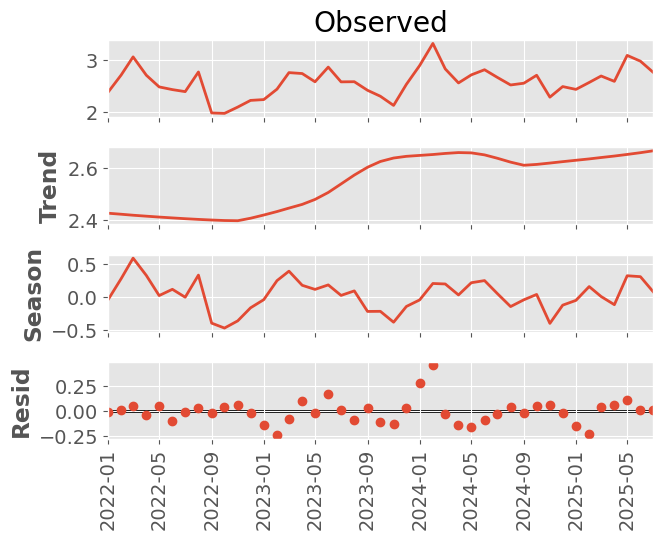

In [116]:

stl_mul.plot()
plt.xticks(rotation='vertical')
plt.show();


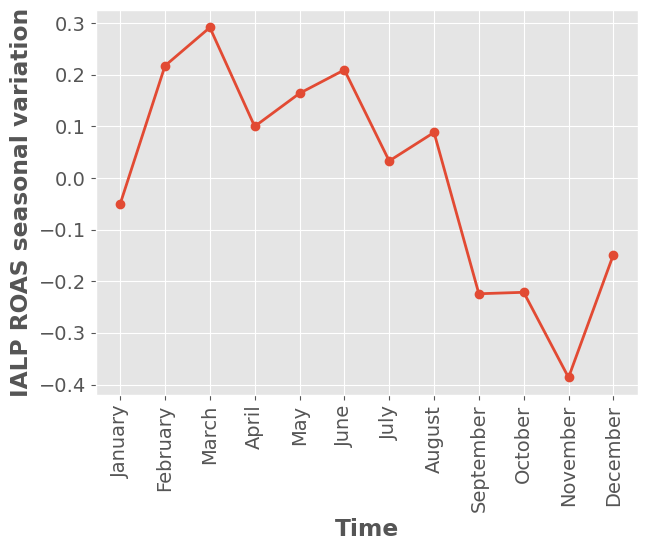

In [117]:
import calendar  
# Visualize the seasonal component
seasonal = stl_mul.seasonal.groupby(stl_mul.seasonal.index.month).mean()
seasonal.plot.line(xlabel="Time", ylabel="IALP ROAS seasonal variation", marker="o")
plt.xticks(range(1, 13), calendar.month_name[1:], rotation='vertical')
plt.show();

### Now we have the seasonal variation

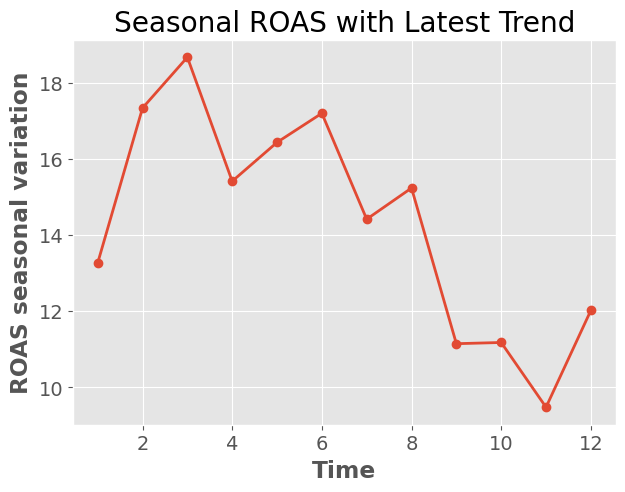

In [118]:
# Get the lastest trend value
latest_trend = np.exp(stl_mul.trend.iloc[-12:]).mean() # use average of last 12 months for stability
seasonal_factor = np.exp(seasonal)
expected_residual = 1.0  # Assume residual is  0 (expected value)

# Forecasted ROAS with latest trend and seasonal factor
monthly_roas = latest_trend * seasonal_factor * expected_residual
monthly_roas.plot.line(xlabel="Time", ylabel="ROAS seasonal variation", marker="o")
plt.title("Seasonal ROAS with Latest Trend")
plt.show();


### （Optional）Add uncertainty estimation below if needed

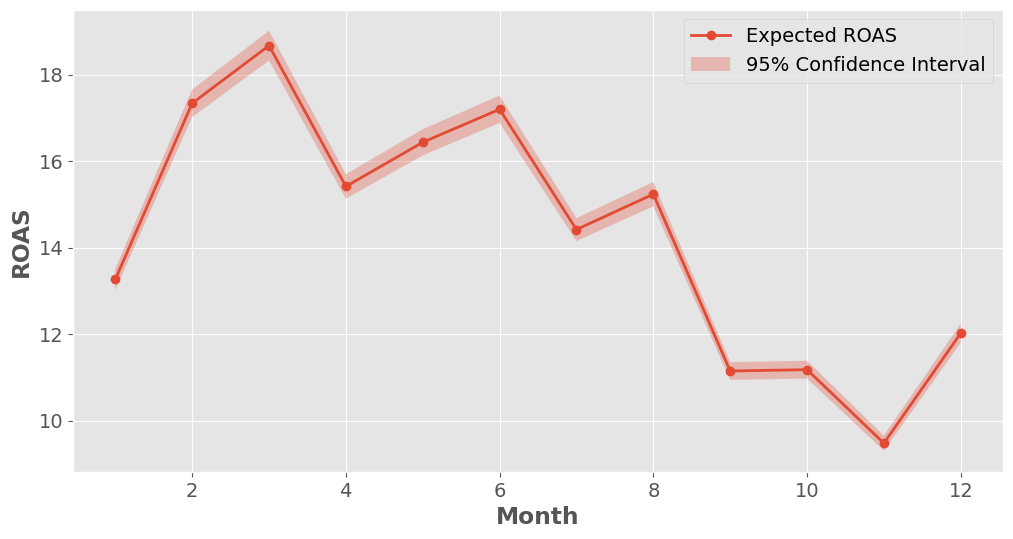

In [119]:
# ROAS with Uncertainty Estimation

# Using relative error as ROAS often has multiplicative errors
residual_std = np.exp(stl_mul.resid).std()
monthly_roas_lower = monthly_roas * (1 - 1.96 * residual_std / monthly_roas.mean()) # 95%CI
monthly_roas_upper = monthly_roas * (1 + 1.96 * residual_std / monthly_roas.mean()) # 95%CI

# Visualize Uncertainty
plt.figure(figsize=(12, 6))
plt.plot(monthly_roas.index, monthly_roas.values, 'o-', label='Expected ROAS')
plt.fill_between(monthly_roas.index, monthly_roas_lower, monthly_roas_upper, 
                alpha=0.3, label='95% Confidence Interval')
plt.xlabel("Month")
plt.ylabel("ROAS")
plt.legend()
plt.show()

In [120]:
# Create a summary DataFrame
monthly_roas_df = pd.DataFrame({
    'Month': range(1, 13),
    'Month_Name': calendar.month_name[1:13],
    'Seasonal_Factor': [seasonal_factor.get(i, 1.0) for i in range(1, 13)],
    'ROAS_Expected': [monthly_roas.get(i, latest_trend) for i in range(1, 13)],
    #'ROAS_Lower_95': [monthly_roas_lower.get(i, latest_trend * 0.8) for i in range(1, 13)],
    #'ROAS_Upper_95': [monthly_roas_upper.get(i, latest_trend * 1.2) for i in range(1, 13)]
})

# Store the results
monthly_roas_df.to_csv('/Users/warroom/Desktop/IALP_analysis/outputs/predictions/roas_seasonal_forecast_with_uncertainty.csv', index=False)

monthly_roas_df 

,Month,Month_Name,Seasonal_Factor,ROAS_Expected
0,1,January,0.951091,13.266348
1,2,February,1.242916,17.336890
2,3,March,1.338584,18.671321
3,4,April,1.105111,15.414715
4,5,May,1.178260,16.435040
5,6,June,1.233031,17.199013
6,7,July,1.033616,14.417455
7,8,August,1.092307,15.236111
8,9,September,0.799199,11.147679
9,10,October,0.801470,11.179358


# Part 3. Budget Proposal

### Now we have the **Revenue Forecast** and the **ROAS Forecast** ready, let's proceed to see how much budget we should propose for next year.

In [121]:

rev_df = rev_result.copy()
roas_df = monthly_roas_df.copy()
# Take the 'Seasonal_Naive' and 'Ensemble_Average' for 2026
rev = rev_df.copy()
rev['Date'] = pd.to_datetime(rev['Date'])
rev_2026 = rev.loc[rev['Date'].between('2026-01-01','2026-12-31'),
                   ['Date','Seasonal_Naive','Ensemble_Average','STL+ARIMA']].copy()
rev_2026 = (rev_2026
            .set_index(rev_2026['Date'].dt.to_period('M').dt.to_timestamp())
            .drop(columns='Date')
            .asfreq('MS'))

# ROAS
roas = roas_df.copy()
roas['Month'] = roas['Month'].astype(int)
roas = roas.set_index('Month')

tmp = rev_2026.copy()
tmp['month_num'] = tmp.index.month
budget = tmp.join(roas, on='month_num')

# =========== IMPORTANT ===========
# Here we set three scenarios for budget planning and adjust the percentile between the two models
# It's acutally quite manual and subjective/experience base, we can further improve it with more advanced methods
budget['Revenue_Low']  = budget['Seasonal_Naive'] + 0.25 * (budget['STL+ARIMA']-budget['Seasonal_Naive'])
budget['Revenue_Base'] = budget['Ensemble_Average']
budget['Revenue_High'] = budget['Seasonal_Naive'] + 0.75 * (budget['STL+ARIMA']-budget['Seasonal_Naive'])

budget['Spend_Low']  = budget['Revenue_Low']  / budget['ROAS_Expected']
budget['Spend_Base'] = budget['Revenue_Base'] / budget['ROAS_Expected']
budget['Spend_High'] = budget['Revenue_High'] / budget['ROAS_Expected']

# 4) Rounding (optional)
#for col in ['Spend_Low','Spend_Base','Spend_High']:
#    budget[col] = budget[col].round(-0)  

# 5) Totals
totals = pd.DataFrame({
    'Revenue_Low' : [budget['Revenue_Low'].sum()],
    'Revenue_Base': [budget['Revenue_Base'].sum()],
    'Revenue_High': [budget['Revenue_High'].sum()],
    'Spend_Low'   : [budget['Spend_Low'].sum()],
    'Spend_Base'  : [budget['Spend_Base'].sum()],
    'Spend_High'  : [budget['Spend_High'].sum()],
})
# Implied ROAS (should be close to ROAS_Expected weighted annual)
totals['Implied_ROAS_Low']  = totals['Revenue_Low']  / totals['Spend_Low']
totals['Implied_ROAS_Base'] = totals['Revenue_Base'] / totals['Spend_Base']
totals['Implied_ROAS_High'] = totals['Revenue_High'] / totals['Spend_High']


In [122]:
budget.to_csv('/Users/warroom/Desktop/IALP_analysis/outputs/predictions/budget_estimation_2026.csv')

In [123]:
budget

,Seasonal_Naive,Ensemble_Average,STL+ARIMA,month_num,Month_Name,Seasonal_Factor,ROAS_Expected,Revenue_Low,Revenue_Base,Revenue_High,Spend_Low,Spend_Base,Spend_High
Date,,,,,,,,,,,,,
2026-01-01,312146.94,366499.271585,420851.603170,1,January,0.951091,13.266348,339323.105792,366499.271585,393675.437377,25577.732677,27626.236572,29674.740466
2026-02-01,272658.68,335423.622897,398188.565795,2,February,1.242916,17.336890,304041.151449,335423.622897,366806.094346,17537.237565,19347.393376,21157.549188
2026-03-01,418240.38,519443.361611,620646.343222,3,March,1.338584,18.671321,468841.870805,519443.361611,570044.852416,25110.267277,27820.385630,30530.503983
2026-04-01,383482.91,499188.063660,614893.217320,4,April,1.105111,15.414715,441335.486830,499188.063660,557040.640490,28630.790467,32383.865066,36136.939665
2026-05-01,394966.68,503415.242446,611863.804892,5,May,1.178260,16.435040,449190.961223,503415.242446,557639.523669,27331.296719,30630.606027,33929.915336
2026-06-01,491252.74,615553.026903,739853.313805,6,June,1.233031,17.199013,553402.883451,615553.026903,677703.170354,32176.433261,35790.021124,39403.608987
2026-07-01,558362.71,631609.417331,704856.124661,7,July,1.033616,14.417455,594986.063665,631609.417331,668232.770996,41268.453972,43808.663360,46348.872749
2026-08-01,237461.42,391475.683194,545489.946389,8,August,1.092307,15.236111,314468.551597,391475.683194,468482.814791,20639.685927,25693.936987,30748.188047
2026-09-01,168672.70,278289.209042,387905.718084,9,September,0.799199,11.147679,223480.954521,278289.209042,333097.463563,20047.307577,24963.869432,29880.431286


In [124]:
totals

,Revenue_Low,Revenue_Base,Revenue_High,Spend_Low,Spend_Base,Spend_High,Implied_ROAS_Low,Implied_ROAS_Base,Implied_ROAS_High
0,4.231143e+06,4.806247e+06,5.381352e+06,287830.074274,328920.529602,370010.98493,14.700141,14.612184,14.543762
